In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("rfm_data.csv")
df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LAST_TO_END   62988 non-null  int64
 1   FLIGHT_COUNT  62988 non-null  int64
 2   SEG_KM_SUM    62988 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [4]:
df.describe()

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
count,62988.000000,62988.000000,62988.000000
mean,176.120102,11.839414,17123.878691
std,183.822223,14.049471,20960.844623
min,1.000000,2.000000,368.000000
25%,29.000000,3.000000,4747.000000
50%,108.000000,7.000000,9994.000000
75%,268.000000,15.000000,21271.250000
max,731.000000,213.000000,580717.000000


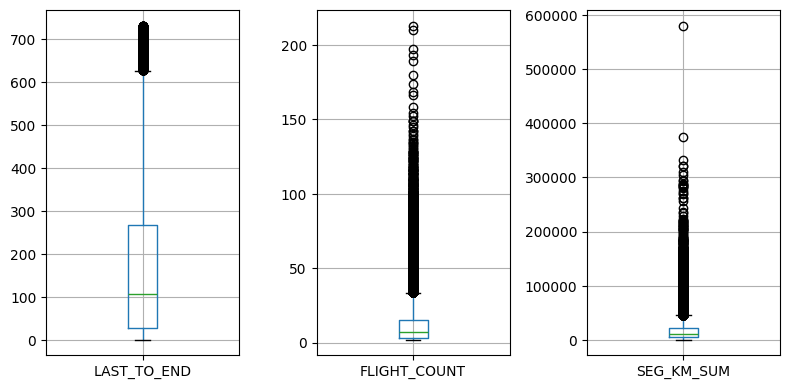

In [5]:
# Outlier Checking

list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df.boxplot(column_name, ax=ax.flatten()[i])
    

plt.tight_layout()
plt.show()

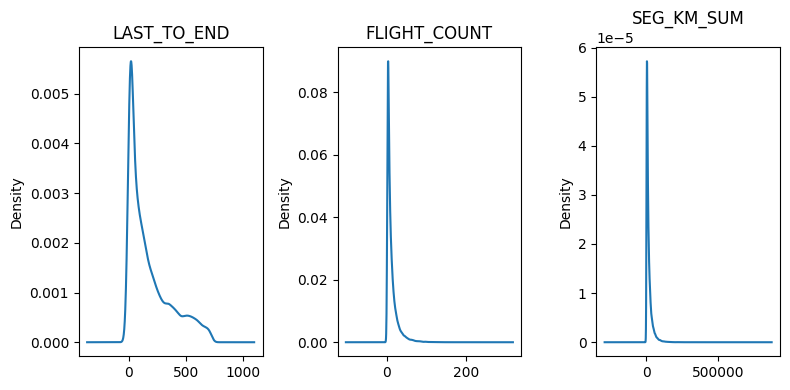

In [6]:
# Distribution of Data
 
list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

In [7]:
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

In [8]:
df

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# Data Pre-processing 

In [9]:
df.corr()

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
LAST_TO_END (R),1.000000,-0.404999,-0.369509
FLIGHT_COUNT (F),-0.404999,1.000000,0.850411
SEG_KM_SUM (M),-0.369509,0.850411,1.000000


In [10]:
from sklearn.preprocessing import QuantileTransformer

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = quantile_trans.fit_transform(df)

In [11]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.368450,3.196950,3.539749
2,-1.166919,3.157160,3.458086
3,-0.050204,1.095556,3.441619
4,-1.525529,3.320460,3.765088
...,...,...,...
62983,0.769761,-5.199338,-2.527826
62984,-0.098013,-0.483658,-0.184738
62985,-0.662724,-5.199338,-1.347152
62986,1.048748,-5.199338,-0.879040


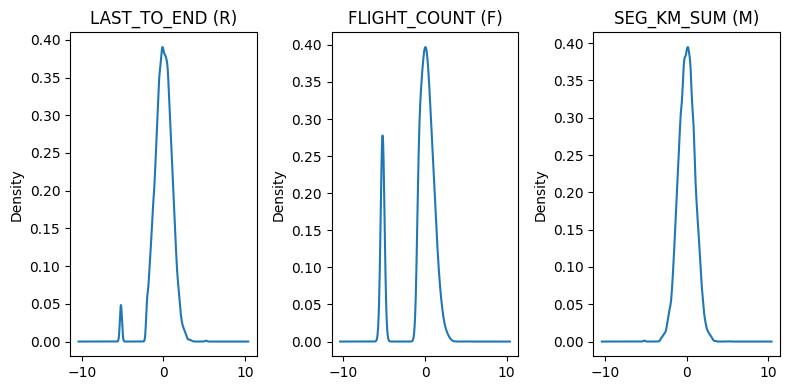

In [12]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df_scaled[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

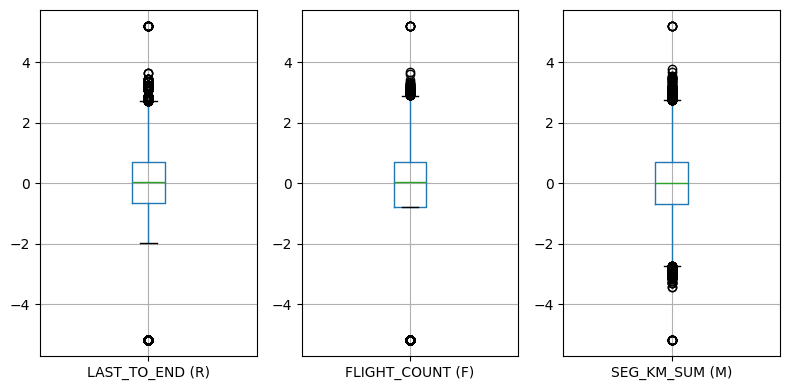

In [13]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 4))

for i, column_name in enumerate(list_columns):
    df_scaled.boxplot(column_name, ax=ax.flatten()[i])

plt.tight_layout()
plt.show()

In [14]:
# Outlier Persentation

for i, j in df_scaled.items():
    q1 = j.quantile(0.25)
    q3 = j.quantile(0.75)
    inter_q = q3 - q1

    j_col = j[(j <= q1 - 1.5 * inter_q) | (j >= q3 + 1.5 * inter_q)]
    percent = np.shape(j_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f" %(i, percent))

Column LAST_TO_END (R) outliers = 1.85
Column FLIGHT_COUNT (F) outliers = 16.66
Column SEG_KM_SUM (M) outliers = 0.76


# Robust Trimmed K Means


In [15]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

df_scaled_np = df_scaled.to_numpy()

RTKM_data = RTKM(df_scaled_np.T)
RTKM_data.perform_clustering(k=3, percent_outliers = 0.10, max_iter = 100, num_members = 2)

#pred clusters return cluster id for data index, pred outliers return outlier index
pred_clusters, pred_outliers = RTKM_data.return_clusters()

Iteration 100
PALM reached maximum number of iterations


In [16]:
print(pred_clusters.shape) #semua titik mendapatkan cluster id
print(pred_outliers.shape) #jumlah percentage yang terpotong menjadi outliers

print(pred_clusters) #return cluster id untuk setiap titik
print(pred_outliers) #return index data yang terdeteksi sebagai outliers

(62988,)
(6301,)
[3 3 3 ... 0 0 0]
[    0     1     2 ... 62966 62974 62975]


In [17]:
#Append dataset sehingga mendapatkan id
cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])

RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

RTKM_result

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
0,-5.199338,5.199338,5.199338,3
1,-1.368450,3.196950,3.539749,3
2,-1.166919,3.157160,3.458086,3
3,-0.050204,1.095556,3.441619,3
4,-1.525529,3.320460,3.765088,3
...,...,...,...,...
62983,0.769761,-5.199338,-2.527826,0
62984,-0.098013,-0.483658,-0.184738,1
62985,-0.662724,-5.199338,-1.347152,0
62986,1.048748,-5.199338,-0.879040,0


In [18]:
# Create a mask for the indices in the DataFrame that need to be modified
mask = np.isin(RTKM_result.index, pred_outliers)

# Use np.where to conditionally replace values in cluster_id
RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])

RTKM_result

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
0,-5.199338,5.199338,5.199338,3-out
1,-1.368450,3.196950,3.539749,3-out
2,-1.166919,3.157160,3.458086,3-out
3,-0.050204,1.095556,3.441619,3-out
4,-1.525529,3.320460,3.765088,3-out
...,...,...,...,...
62983,0.769761,-5.199338,-2.527826,0
62984,-0.098013,-0.483658,-0.184738,1
62985,-0.662724,-5.199338,-1.347152,0
62986,1.048748,-5.199338,-0.879040,0


In [19]:
# Use boolean indexing to filter out rows based on indices_to_remove
RTKM_result_filtered = RTKM_result[~RTKM_result.index.isin(pred_outliers)]

RTKM_result_filtered

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
230,0.388430,0.403356,2.480720,1
245,-0.042668,0.403356,2.473224,1
335,0.186756,0.482248,2.363910,1
349,0.912774,0.482248,2.328635,1
369,-0.132113,0.324254,2.312504,1
...,...,...,...,...
62983,0.769761,-5.199338,-2.527826,0
62984,-0.098013,-0.483658,-0.184738,1
62985,-0.662724,-5.199338,-1.347152,0
62986,1.048748,-5.199338,-0.879040,0


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

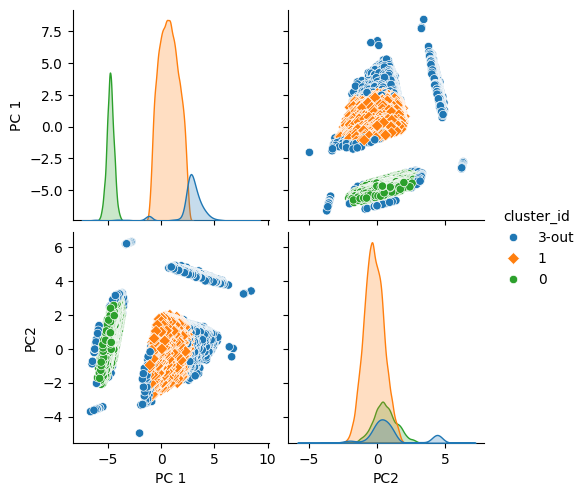

<Figure size 800x800 with 0 Axes>

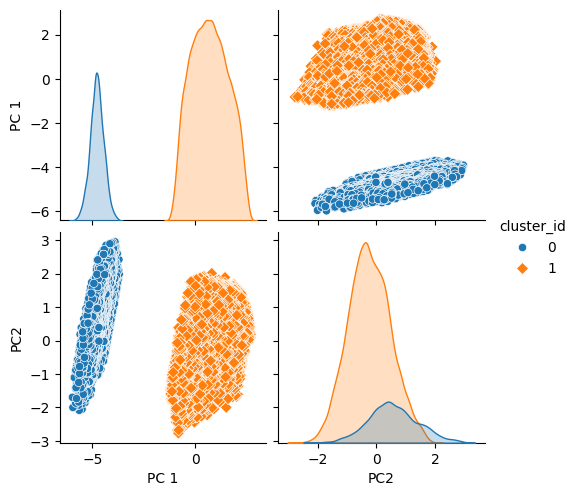

In [20]:
# Visualisasi untuk example k = 3
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = RTKM_result.loc[:, RTKM_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])


#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = RTKM_result_filtered.loc[:, RTKM_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

## Elbow method untuk RTKM

# Trimmed K-MEANS (Manual)

In [22]:
import numpy as np
import pandas as pd

def initialize_centers(data, n_clusters):
    # Randomly initialize cluster centers
    indices = np.random.choice(len(data), n_clusters, replace=False)
    centers = data.iloc[indices].values
    return centers

def assign_clusters(data, centers):
    # Assign each data point to the nearest cluster center
    distances = np.linalg.norm(data.values - centers[:, np.newaxis], axis=2)
    labels = np.argmin(distances, axis=0)
    return labels

def update_centers(data, labels, n_clusters):
    # Update cluster centers based on the mean of assigned data points
    centers = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
    return centers

def trimmed_kmeans(data, n_clusters, out_percentage, max_iter=300):
    # Randomly initialize cluster centers
    centers = initialize_centers(data, n_clusters)
    percentage = 100 - out_percentage
    
    for _ in range(max_iter):
        # Assign each data point to the nearest cluster center
        labels = assign_clusters(data, centers)
        
        # Calculate distances to cluster centers
        distances = np.linalg.norm(data.values - centers[labels], axis=1)
        
        # Calculate the threshold for trimming
        threshold = np.percentile(distances, percentage)
        
        # Identify outliers based on the threshold
        outliers = data[distances > threshold]
        
        # Update cluster centers using non-outliers
        centers = update_centers(data[distances <= threshold], labels[distances <= threshold], n_clusters)
    
    # Create a DataFrame for outliers
    outlier_df = pd.DataFrame(outliers, columns=data.columns)
    
    # Add 'cluster_id' column to the original data
    data['cluster_id'] = labels
    
    # Create a DataFrame for clustered data
    clustered_df = data[data['cluster_id'].isin(np.unique(labels))]
    
    return clustered_df, outlier_df

'''
# Example usage:
data = pd.DataFrame({
    'Type1': [0.0, 0.0, 473.6, 0.0, 0.0, 100.0, 200.0, 300.0],
    'Type2': [0.0, 63.72, 174.0, 996.0, 524.91, 50.0, 150.0, 250.0],
    'Type3': [0.0, 0.0, 31.6, 160.92, 0.0, 10.0, 20.0, 30.0]
})
'''

n_clusters = 2
trim_percentage = 20

'''
clustered_df, outlier_df = trimmed_kmeans(df_scaled, n_clusters, trim_percentage)

print("Clustered Data:")
print(clustered_df)
print("\nOutliers:")
print(outlier_df)
'''

'\nclustered_df, outlier_df = trimmed_kmeans(df_scaled, n_clusters, trim_percentage)\n\nprint("Clustered Data:")\nprint(clustered_df)\nprint("\nOutliers:")\nprint(outlier_df)\n'

In [23]:
'''
#reduce data two dimention
#clustered
pca = PCA(n_components=2)
df_pca = pca.fit_transform(clustered_df)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
df_pca['cluster_id'] = clustered_df.loc[:, clustered_df.columns.isin(['cluster_id'])]

#outliers
df_pca_out = pca.fit_transform(outlier_df)
df_pca_out= pd.DataFrame(df_pca_out, columns=['PC 1', 'PC2'])
df_pca_out['cluster_id'] = "out"


#merge
df_pca_merge = pd.concat([df_pca, df_pca_out])
df_pca_out
'''

'\n#reduce data two dimention\n#clustered\npca = PCA(n_components=2)\ndf_pca = pca.fit_transform(clustered_df)\n\ndf_pca = pd.DataFrame(df_pca, columns=[\'PC 1\', \'PC2\'])\ndf_pca[\'cluster_id\'] = clustered_df.loc[:, clustered_df.columns.isin([\'cluster_id\'])]\n\n#outliers\ndf_pca_out = pca.fit_transform(outlier_df)\ndf_pca_out= pd.DataFrame(df_pca_out, columns=[\'PC 1\', \'PC2\'])\ndf_pca_out[\'cluster_id\'] = "out"\n\n\n#merge\ndf_pca_merge = pd.concat([df_pca, df_pca_out])\ndf_pca_out\n'

In [24]:
'''
#plot data
import seaborn as sns 

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca_merge, hue='cluster_id', markers=["o", "D"])
'''

'\n#plot data\nimport seaborn as sns \n\nplt.figure(figsize=(8,8))\nsns.pairplot(data=df_pca_merge, hue=\'cluster_id\', markers=["o", "D"])\n'